# This notebook uses Hail Library to subset 1000Genomes data using the following filter.

### You can run this notebook on an AWS EMR cluster
### - https://aws.amazon.com/marketplace/pp/AEHRC-VariantSpark-Notebook/B07YVND4TD
### - https://youtu.be/qum5Q8sQQtw

### Filtered data can be used as input for PEPS 
### https://github.com/aehrc/PEPS

## 1- Filter out multi-allelic Variants
## 2- Filter out Variants with call rate less than 1
## 3- Filter out Variants with p-value HWE less than 0.0000001
## 4- Filter out Variants with MAF less than 0.2
## 5- Filter out Variants with p-value less than 0.0001 (linear regression with super population as phenotype)
## 6- Filter out indels and structural variants (keep only SNPs)

### To run this notebook change the path below.

In [4]:
numCPU=128
numPartition=numCPU*2
DIR='path to s3 folder to store data'

# Intialisation

In [1]:
%%juspark
{"spark.driver.memory":"24G","spark.jars":"/home/hadoop/miniconda2/envs/jupyter/lib/python2.7/site-packages/varspark/jars/variant-spark_2.11-0.2.0-all.jar"}


PySpark initialised: spark context available as sc


In [2]:
import hail
import varspark.hail
from hail import KeyTable
from hail.keytable import asc
from hail.keytable import desc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from math import log, isnan
from pprint import pprint
from decimal import Decimal
from pyspark.sql.functions import *
from datetime import datetime

In [3]:
hc = hail.HailContext(sc)

Running on Apache Spark version 2.2.1
SparkUI available at http://ip-172-31-29-199.ap-southeast-2.compute.internal:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.1-20613ed


# Path to data

In [5]:
G1000DIR='s3://1000genomes/release/20130502/'
G1000File = [
    G1000DIR+'ALL.chr1.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr2.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr3.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr4.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr5.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr6.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr7.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr8.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr9.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr10.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr11.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr12.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr13.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr14.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr15.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr16.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr18.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr19.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr20.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr21.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz',
    G1000DIR+'ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'
]

In [6]:
expr_maf = 'va.qc.MAF = if(va.qc.AF > 0.5) (1 - va.qc.AF) else (va.qc.AF)'
expr_filter = 'va.qc.callRate == 1 && va.qc.MAF > 0.2 && va.qc.pHWE > 0.0000001'

vds = hc.import_vcf(path=G1000File, force_bgz=True)\
.annotate_variants_expr('va.info=0')\
.repartition(numPartition)\
.cache()\
.split_multi()\
.filter_variants_expr('va.wasSplit', keep=False)\
.variant_qc().annotate_variants_expr(expr_maf)\
.filter_variants_expr(expr_filter)\
.ld_prune(r2=0.1, memory_per_core=1024, num_cores=numCPU)

2020-01-08 22:34:35 Hail: INFO: Multiallelic variants detected. Some methods require splitting or filtering multiallelics first.
2020-01-08 22:34:37 Hail: INFO: Coerced almost-sorted dataset
2020-01-08 23:11:16 Hail: INFO: Running LD prune with nSamples=2504, nVariants=2540912, nPartitions=256, and maxQueueSize=397094.
2020-01-08 23:29:38 Hail: INFO: LD prune step 1 of 3: nVariantsKept=131828, nPartitions=256, time=18m21.7s
2020-01-08 23:29:42 Hail: INFO: LD prune step 2 of 3: nVariantsKept=131343, nPartitions=384, time=4.282s
2020-01-08 23:29:46 Hail: INFO: Coerced sorted dataset
2020-01-08 23:29:48 Hail: INFO: LD prune step 3 of 3: nVariantsKept=131340, time=5.649s


In [7]:
vds.write(DIR+'SelectedVariant.vds')

In [8]:
vds.count()

(2504L, 131340L)

In [5]:
vds = hc.read(DIR+'SelectedVariant.vds').repartition(numPartition).cache()

# Annotate poulation

In [7]:
sa = hc.import_table(DIR+'igsr_samples.tsv', impute=True)\
.select(['Sample name', 'Sex', 'Superpopulation code']).rename(['sample','sex','pop']).key_by('sample')\
.annotate('pc = if(pop=="SAS") 0.1 else (if(pop=="EAS") 0.2 else (if(pop=="EUR") 0.3 else (if(pop=="AMR") 0.4 else 0.5)))')


2020-01-09 00:12:02 Hail: INFO: Reading table to impute column types
2020-01-09 00:12:03 Hail: INFO: Finished type imputation
  Loading column `Sample name' as type String (imputed)
  Loading column `Sex' as type String (imputed)
  Loading column `Biosample ID' as type String (imputed)
  Loading column `Population code' as type String (imputed)
  Loading column `Population name' as type String (imputed)
  Loading column `Superpopulation code' as type String (imputed)
  Loading column `Superpopulation name' as type String (imputed)
  Loading column `Population elastic ID' as type String (imputed)
  Loading column `Data collections' as type String (imputed)


In [8]:
vds = vds.annotate_samples_table(sa, root='sa.pheno')

In [9]:
vds.samples_table().to_pandas().groupby('sa.pheno.pop').count()

,s,sa.pheno.sex,sa.pheno.pc
sa.pheno.pop,,,
AFR,661,661,661
AMR,347,347,347
EAS,504,504,504
EUR,503,503,503
SAS,489,489,489


# Filter SNPs that describes populations

In [10]:
vds = vds.linreg(root='va.pp' , y='sa.pheno.pc')

2020-01-09 00:13:19 Hail: INFO: Running linear regression on 2504 samples with 1 covariate including intercept...


In [11]:
import sys

In [ ]:
!{sys.executable} -m pip install https://github.com/khramts/assocplots/archive/master.zip

In [13]:
%matplotlib inline

#Here we set the dimensions for the figures in this notebook
import matplotlib as mpl
mpl.rcParams['figure.dpi']=150
mpl.rcParams['savefig.dpi']=150
mpl.rcParams['figure.figsize']=7.375, 3.375

from assocplots.manhattan import *
from assocplots.qqplot import *

chrs = [str(i) for i in range(1,23)]
chrs_names = np.array([str(i) for i in range(1,23)])
chrs_names[1::2] = ''

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in [0.0,0.33,0.67,0.90]]

# Alternatively you can input colors by hand
from matplotlib.colors import hex2color
colors = ['#1b9e77', "#d95f02", '#7570b3', '#e7298a']
# Converting from HEX into RGB
colors = [hex2color(colors[i]) for i in range(len(colors))]

In [14]:
pd = vds.filter_variants_expr('va.pp.pval > 0 && va.pp.pval < 0.0001')\
.variants_table().flatten().select(['v','va.pp.pval']).rename(['v','pval']).order_by('pval').to_pandas()

/home/hadoop/miniconda2/envs/jupyter/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


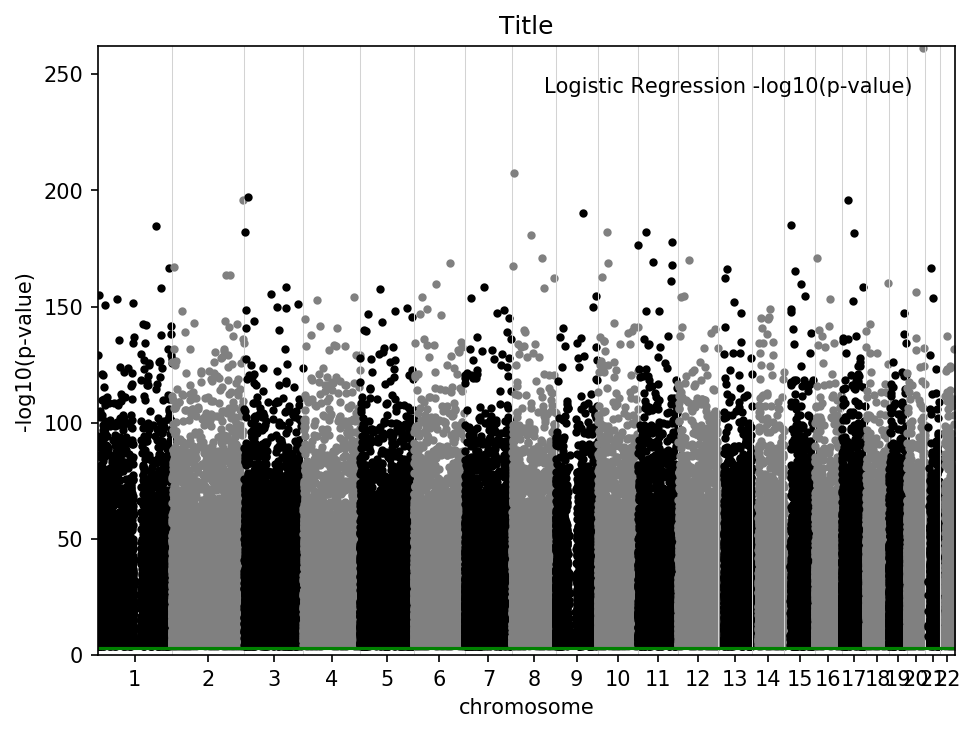

In [15]:
mpl.rcParams['figure.figsize']=7.375, 5.375
manhattan(  p1=pd['pval'] , pos1=pd['v.start'], chr1=pd['v.contig'].astype(str), label1='Logistic Regression -log10(p-value)',
            cut = 0,
            lines = [3],
          scaling='-log10')
plt.show()

In [16]:
vds = vds.filter_variants_expr('va.pp.pval > 0.01')
vds.count()

(2504L, 24979L)

In [20]:
pd = vds.filter_variants_expr('va.pp.pval > 0')\
.variants_table().flatten().select(['v','va.pp.pval']).rename(['v','pval']).order_by('pval').to_pandas()

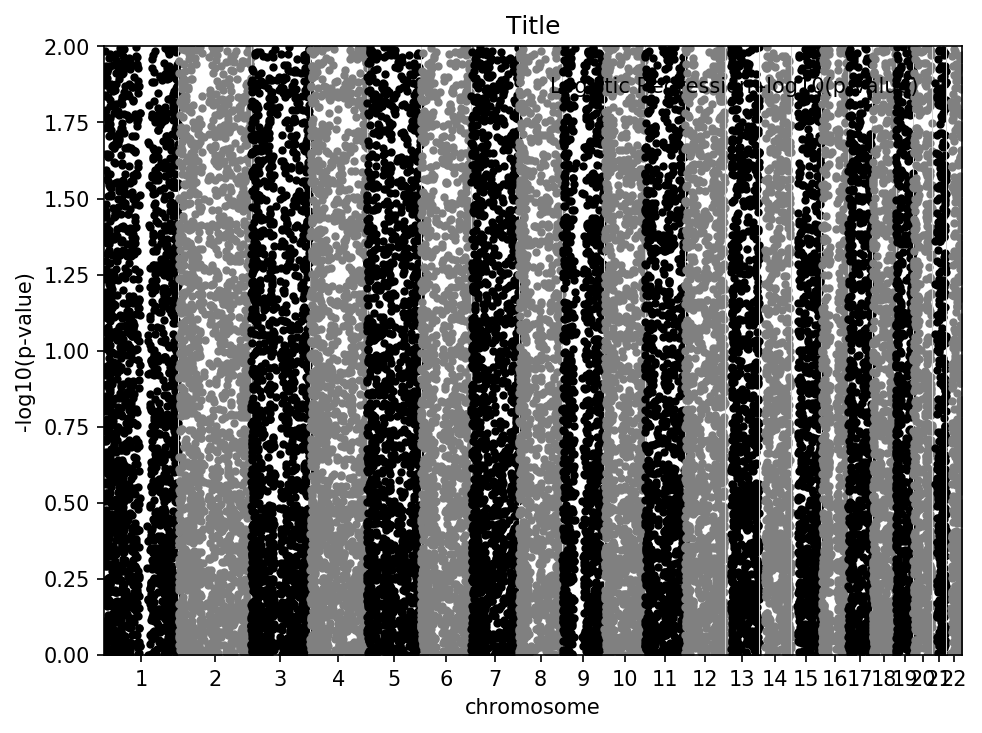

In [22]:
mpl.rcParams['figure.figsize']=7.375, 5.375
manhattan(  p1=pd['pval'] , pos1=pd['v.start'], chr1=pd['v.contig'].astype(str), label1='Logistic Regression -log10(p-value)',
            cut = 0,
            lines = [3],
          scaling='-log10')
plt.show()

2020-01-09 00:20:27 Hail: INFO: Running PCA with 2 components...


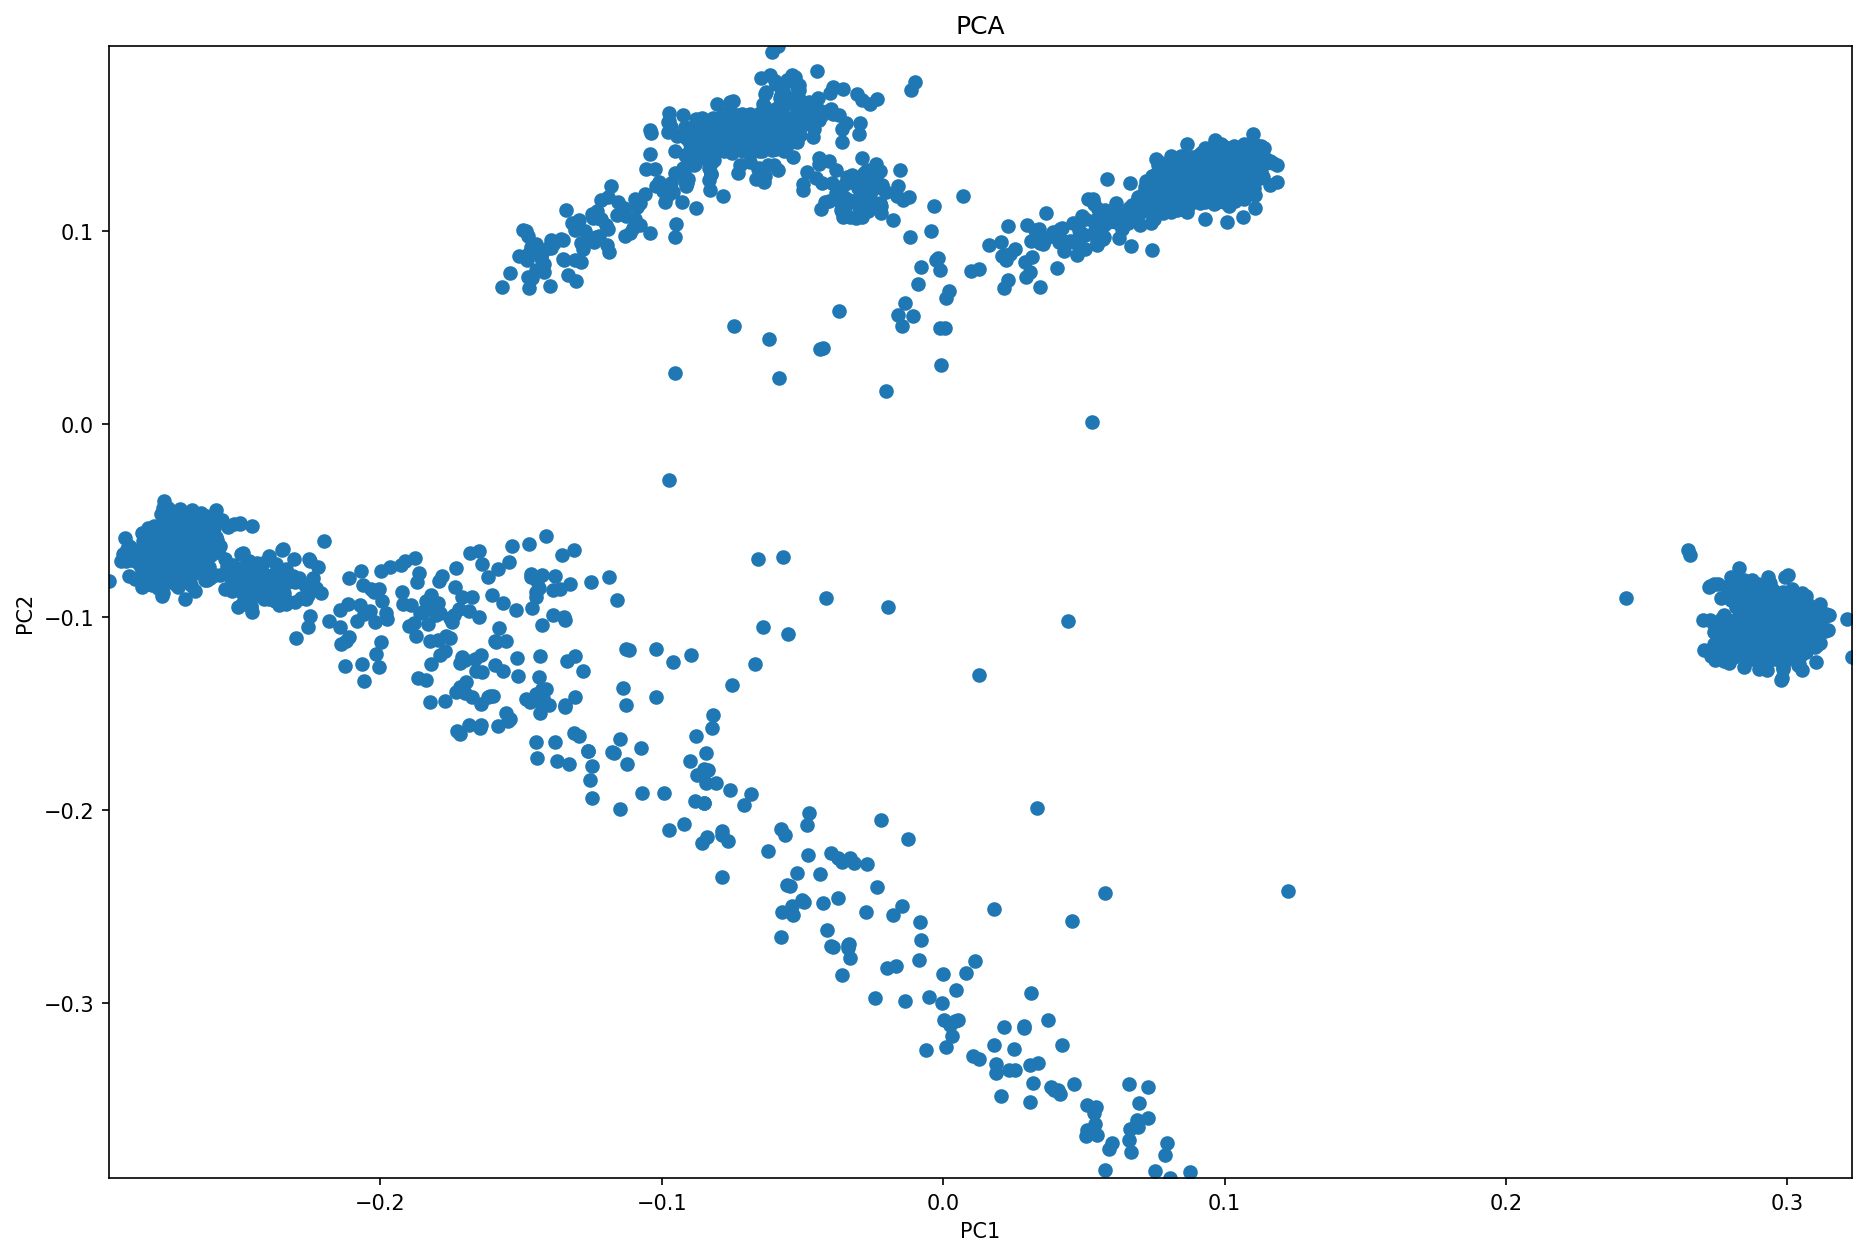

Struct{
     pheno: Struct{
         sex: String,
         pop: String,
         pc: Double
     },
     pca: Struct{
         PC1: Double,
         PC2: Double
     }
 }


In [23]:
pca_kt = vds.cache().pca(k=2, scores='sa.pca_score')\
.samples_table().flatten().select(['s', 'sa.pca_score.PC1', 'sa.pca_score.PC2'])\
.rename(['s', 'PC1', 'PC2'])

pca_table = pca_kt.to_pandas()


#colors = {True: 'yellow', False: 'black'}
plt.figure(figsize=(15,10))
plt.scatter(pca_table["PC1"], pca_table["PC2"])
plt.xlim(pca_table["PC1"].min(), pca_table["PC1"].max())
plt.ylim(pca_table["PC2"].min(), pca_table["PC2"].max())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")

plt.show()

vds = vds.annotate_samples_table(pca_kt, root='sa.pca')
pprint(vds.sample_schema)

# Remove non-SNP (indels)

In [49]:
vds = vds.filter_variants_expr('v.altAlleles[0].alt.length()!=1 || v.altAlleles[0].ref.length()!=1', keep=False)
vds.count()

(2504L, 17373L)

# Export as VCF

In [52]:
vds.export_vcf(DIR+'PEPS-1000Genome-Subset-A.vcf.bgz')

2020-01-09 00:43:47 Hail: INFO: while writing:
    s3://csiro-tb/home/bay041/PolyEpi/all-snps.vcf.bgz
  merge time: 947.667ms
